<a href="https://colab.research.google.com/github/skromnjaga/DICDataCrackExtraction/blob/master/crack_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
!wget --no-cache -q https://raw.githubusercontent.com/skromnjaga/DICDataCrackExtraction/master/dic_data_crack_extraction.py -O dic_data_crack_extraction.py

In [16]:
from dic_data_crack_extraction import *

In [17]:
from pathlib import Path

data_path = './data'

Path(data_path).mkdir(parents=True, exist_ok=True)

Setup processing constants

In [18]:
DATA_PATH = './data'
RESULT_PATH = './results'
DATA_SETS = ('R_6_28_12_2021', 'O16_12_08_2021', 'H_9_2_17_12_2021', 'R_Nemo_10_03_2022')
REMOTE_DIC_DATA_LINKS = ('https://yadi.sk/d/H1vUyhigblohFA', 'https://yadi.sk/d/rn3MWI0-RfzIcg', 'https://yadi.sk/d/9jzHGOotHuD9xQ', 'https://yadi.sk/d/rMMyPa9YhAxVtw')
REMOTE_AE_DATA_LINKS = ('', 'https://yadi.sk/d/4P30t4f32ndk7A', 'https://yadi.sk/d/tipwEmUdy2OTzg', 'https://yadi.sk/d/MfUAJK3Y7eQonA')
CRACK_LOCATIONS = ('right', 'bottom', 'left', 'left')
AE_FILES = ('P6.mat', 'Shaft(O16).mat', 'H 9-2.mat', 'Rail(10.03.22).mat')
AE_MOMENTS = (0, 10, 20, 1132)
AE_COUNTS = (0, 5, 30, 6)
LAST_RECSS = (8102, 1199, 5758, 2666)
THRESHOLDS = (70, 115, 70, 60)
USE_OTSUS = (True, False, False, False)

Setup processing parameters

In [19]:
# Index of data set to calculate
DATA_SET_INDEX = 3

# Threshold to find crack
THRESHOLD_RATIO = 10
# Threshold exceed repetitions to detect crack
THRESHOLD_REPETITIONS = 3
# Direction to filter exceeding time in accsending order
DIRECTION = 'backward'
# Threshold to find crack ROI
THRESHOLD = THRESHOLDS[DATA_SET_INDEX]
# Use Otsu to find threshold
USE_OTSU = USE_OTSUS[DATA_SET_INDEX]
# Force to recalculate results with the same parameters
FORCE_TO_RECALCULATE = True

# Show plots for calculation results
SHOW_CRACK_ROI = False
SHOW_CRACK_DETECTED_STRAIN_FIELD = False
SHOW_AVG_MAX_STRAIN = True
SHOW_THRESHOLD_EXCEEDED_TIMES = True
SHOW_CRACK_LENGTH_VS_TIME = True
SHOW_THRESHOLDS_TIMES = True

DATA_SET_NAME = DATA_SETS[DATA_SET_INDEX]
REMOTE_DIC_DATA_LINK = REMOTE_DIC_DATA_LINKS[DATA_SET_INDEX]
REMOTE_AE_DATA_LINK = REMOTE_AE_DATA_LINKS[DATA_SET_INDEX]

# Last record to process (before destruction)    
LAST_REC = LAST_RECSS[DATA_SET_INDEX]
CRACK_LOCATION = CRACK_LOCATIONS[DATA_SET_INDEX]
# AE data
AE_FILE = AE_FILES[DATA_SET_INDEX]
AE_MOMENT = AE_MOMENTS[DATA_SET_INDEX]
AE_COUNT = AE_COUNTS[DATA_SET_INDEX]

Start processing

In [20]:
print(f'Dataset "{DATA_SET_NAME}" choosed to process..')

# Try to load previous results
parameters, results = try_load_results(RESULT_PATH, DATA_SET_NAME)

# Detect if parameters are changed and recalculation is required
parameters_changed = True
if parameters is not None:
    parameters_changed = (float(parameters[0]) != THRESHOLD_RATIO or int(parameters[1]) != THRESHOLD_REPETITIONS or
                          parameters[2] != DIRECTION or int(parameters[3]) != LAST_REC or int(parameters[4]) != THRESHOLD or
                          parameters[5] != str(USE_OTSU) or parameters[6] != CRACK_LOCATION)

# Determine if processing data is required
process_data = FORCE_TO_RECALCULATE or results == None or parameters_changed

if results is None:
    print('Previous results no found...')
if parameters_changed:
    print('Loaded results parameteres are changed, recalculation is required...')
if FORCE_TO_RECALCULATE:
    print('Processing forced to recalculate...')
if process_data:
    print('Starting processing...')
else:
    print('Processing skipped, using loaded previous results...')

# Load data if required
if process_data or SHOW_CRACK_ROI or SHOW_CRACK_DETECTED_STRAIN_FIELD:
    # Load data from file
    try:
        x_coords, y_coords, time_counts, data = load_data_from_file(DATA_SET_NAME, DATA_PATH)
    except FileNotFoundError:
        # Try to load remote data
        print(f'Local files and raw data from DaVis not found. Try to download data from remote...')
        download_from_yandex_disk(REMOTE_DIC_DATA_LINK, DATA_PATH)
        print('Try to open downloaded file again...')
        x_coords, y_coords, time_counts, data = load_data_from_file(DATA_SET_NAME, DATA_PATH)

# Load AE data from .mat file if filename specified   
if AE_FILE != '':
    download_from_yandex_disk(REMOTE_AE_DATA_LINK, DATA_PATH)
    mat = scipy.io.loadmat(DATA_PATH + '/' + AE_FILE)
    ae_data = [mat['time'].flatten(), mat['events'].flatten(), AE_MOMENT, AE_COUNT]
else:
    ae_data = None

# Process data
if process_data:        
    # Cut time for last record
    time_counts = time_counts[:LAST_REC]        

    # Find crack ROI, crack points coordinates and crack length
    crack_ROI, crack_points, crack_length = get_crack_ROI(data, x_coords, y_coords, LAST_REC, THRESHOLD, USE_OTSU, CRACK_LOCATION)
    
    # For each strain field find field in crack, avg and max field, find first index with crack founded
    field_in_crack, avg_normal_strain, max_normal_strain, first_crack_index = process_crack(data, crack_ROI, crack_points, LAST_REC, THRESHOLD_RATIO, THRESHOLD_REPETITIONS)

    print(f'Crack founded on {first_crack_index} record - {time_counts[first_crack_index]} s')
    
    # Calculate for each crack point time when threshold is exceeded
    times_threshold_exceeded, result_time_threshold_exceeded = get_threshold_exceed_times(time_counts, field_in_crack, avg_normal_strain, THRESHOLD_RATIO, direction=DIRECTION)

    # Save processing results
    parameters = np.array([THRESHOLD_RATIO, THRESHOLD_REPETITIONS, DIRECTION, LAST_REC, THRESHOLD, USE_OTSU, CRACK_LOCATION])
    results = {'crack_ROI': crack_ROI, 'crack_points': crack_points, 'crack_length': crack_length, 'field_in_crack': field_in_crack,
                'avg_normal_strain': avg_normal_strain, 'max_normal_strain': max_normal_strain, 'first_crack_index': first_crack_index,
                'times_threshold_exceeded': times_threshold_exceeded, 'result_time_threshold_exceeded': result_time_threshold_exceeded,
                'time_counts': time_counts}

    save_process_result(RESULT_PATH, DATA_SET_NAME, parameters, results)
else:
    # Parsing loaded data from previous results
    crack_ROI = results[()]['crack_ROI']
    crack_points = results[()]['crack_points']
    crack_length = results[()]['crack_length']
    field_in_crack = results[()]['field_in_crack']
    avg_normal_strain = results[()]['avg_normal_strain']
    max_normal_strain = results[()]['max_normal_strain']
    first_crack_index = results[()]['first_crack_index']
    times_threshold_exceeded = results[()]['times_threshold_exceeded']
    result_time_threshold_exceeded = results[()]['result_time_threshold_exceeded']
    time_counts = results[()]['time_counts']

Dataset "R_Nemo_10_03_2022" choosed to process..
Processing forced to recalculate...
Starting processing...
Data file ./data/R_Nemo_10_03_2022.npz loaded with 2667 records.
Download link for remote data obtained https://downloader.disk.yandex.ru/disk/89d9081b86f52d9a4ca19650b063fac25b43653db30b74204de9f8ace5a07afe/628f3dbd/7_s6CsP4wygaRWb0af6Teq7ibd77xGnxcry6sS_k4NLdR5NIcIufE_8xHmu_TqYD61sA1mihNLPFzvgyVKYvpQ%3D%3D?uid=0&filename=Rail%2810.03.22%29.mat&disposition=attachment&hash=ujE9d2IKEkrQHYxNBgVwgloCoHt3w7lTJyhdVKyXwq0LTJARiH8DFZpaxDXKLTU2q/J6bpmRyOJonT3VoXnDag%3D%3D%3A&limit=0&content_type=application%2Foctet-stream&owner_uid=45152461&fsize=8385&hid=2ab0956b99254b5dcbfc9cf5d31064f1&media_type=data&tknv=v2
Start downloading...
File "Rail(10.03.22).mat" succefully downloaded to "./data"
Crack founded on 920 record - 759.7201149699977 s
Processing results saved to ./results/R_Nemo_10_03_2022_results.npz file


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Plotting graphs

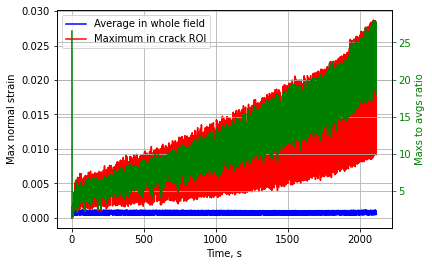

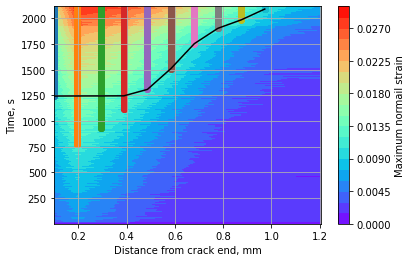

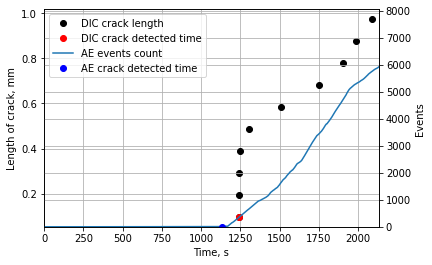

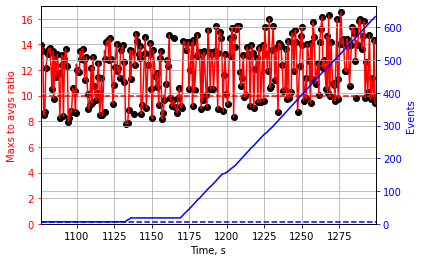

In [21]:
if SHOW_CRACK_ROI:
    draw_crack_ROI(crack_ROI, crack_points, data, LAST_REC, CRACK_LOCATION)

if SHOW_CRACK_DETECTED_STRAIN_FIELD:
    draw_crack_detected_strain_field(data, crack_ROI, first_crack_index, CRACK_LOCATION)

if SHOW_AVG_MAX_STRAIN:
    draw_avg_max_normal_strain(time_counts, avg_normal_strain, max_normal_strain)

if SHOW_THRESHOLD_EXCEEDED_TIMES:
    draw_threshold_exceeded_times(time_counts, crack_length, field_in_crack, times_threshold_exceeded, result_time_threshold_exceeded)

if SHOW_CRACK_LENGTH_VS_TIME:
    draw_crack_length_vs_time(result_time_threshold_exceeded, crack_length, ae_data)

if SHOW_THRESHOLDS_TIMES:
    draw_thresholds_times(time_counts, result_time_threshold_exceeded, avg_normal_strain, max_normal_strain, THRESHOLD_RATIO, ae_data)